<a href="https://colab.research.google.com/github/luciainnocenti/IncrementalLearning/blob/Lucia/TestAndTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import GitHub repository

In [0]:
import os
import logging
import sys


In [2]:
if not os.path.isdir('./DatasetCIFAR'):
  !git clone -b Lucia https://github.com/luciainnocenti/IncrementalLearning.git
  !mv 'IncrementalLearning' 'DatasetCIFAR'

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 194 (delta 31), reused 18 (delta 8), pack-reused 137
Receiving objects: 100% (194/194), 156.17 KiB | 929.00 KiB/s, done.
Resolving deltas: 100% (107/107), done.


# Import packages

In [0]:
from DatasetCIFAR.data_set import Dataset 
from DatasetCIFAR import ResNet
from DatasetCIFAR import utils
from torchvision import models
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
from torch.nn import functional as F

# Hyper-Parameters

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'
BATCH_SIZE = 128
NUM_WORKERS = 100
TASK_SIZE = 10
############################################
#NUM_EPOCHS = 70
NUM_EPOCHS = 5
############################################


WEIGHT_DECAY = 0.00001
LR = 2
STEP_SIZE = [49,63]
GAMMA = 1/5

# Define Network

In [0]:
resNet = ResNet.resnet32(num_classes=100)
resNet = resNet.to(DEVICE)

In [0]:
resnet_transformer = transforms.Compose([transforms.Resize(32), 
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])


# Define DataSets

In [7]:
trainDS = Dataset(train=True, transform = resnet_transformer)
testDS = Dataset(train=False, transform = resnet_transformer)

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


# Useful plots

The function plotEpoch plots, at the end of each task, how accuracy and loss change during the training phase. It show

*   Validation and Training Accuracy
*   Validation and Training Loss

The function plotTask, for each task, how the accuracy on the validation set change when adding new tasks


In [0]:
def plotTask(pars_tasks):
  import numpy as np
  import matplotlib.pyplot as plt

  x_tasks =  np.linspace(10, 100, 10)

  plt.plot(x_tasks, pars_tasks ,'b', label='Accuracy')
  plt.xlabel("Epoch")
  plt.title('Accuracy over classes')
  plt.legend(['Validation Accuracy'])
  plt.grid(True)
  plt.show()



# Train and evaluation phase

[2.0]     [2.0]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:396: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


At step  0  and at epoch =  0  the loss is =  0.038654353469610214  and accuracy is =  0.1464
Validation Loss: 2110.335693359375 Validation Accuracy : 0.0
[2.0]     [2.0]
At step  0  and at epoch =  1  the loss is =  0.03378806635737419  and accuracy is =  0.2286
Validation Loss: 2110.335693359375 Validation Accuracy : 0.0
[2.0]     [2.0]
At step  0  and at epoch =  2  the loss is =  0.031861208379268646  and accuracy is =  0.2848
Validation Loss: 2110.335693359375 Validation Accuracy : 0.0
[2.0]     [2.0]
At step  0  and at epoch =  3  the loss is =  0.029518013820052147  and accuracy is =  0.3292
Validation Loss: 2110.335693359375 Validation Accuracy : 0.0
[2.0]     [2.0]
At step  0  and at epoch =  4  the loss is =  0.02722165919840336  and accuracy is =  0.365
Validation Loss: 2110.335693359375 Validation Accuracy : 0.0


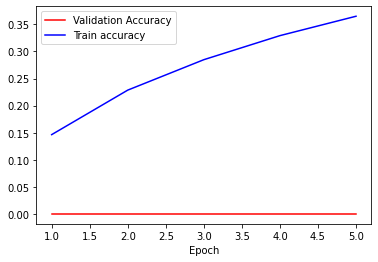

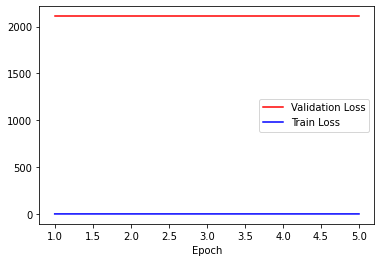

[2.0]     [2.0]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:396: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


At step  10  and at epoch =  0  the loss is =  nan  and accuracy is =  0.02
Validation Loss: 0.08376889675855637 Validation Accuracy : 0.137
[2.0]     [2.0]
At step  10  and at epoch =  1  the loss is =  nan  and accuracy is =  0.0
Validation Loss: 0.08376889675855637 Validation Accuracy : 0.137
[2.0]     [2.0]
At step  10  and at epoch =  2  the loss is =  nan  and accuracy is =  0.0
Validation Loss: 0.08376889675855637 Validation Accuracy : 0.137
[2.0]     [2.0]


In [0]:
pars_tasks = []
test_indexes = []

for task in range(0, 100, TASK_SIZE):
  pars_tasks.insert(task, 0)

for task in range(0, 100, TASK_SIZE):

  train_indexes = trainDS.__getIndexesGroups__(task)
  test_indexes = test_indexes + testDS.__getIndexesGroups__(task)

  train_dataset = Subset(trainDS, train_indexes)
  test_dataset = Subset(testDS, test_indexes)

  train_loader = DataLoader( train_dataset, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)
  test_loader = DataLoader( test_dataset, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE )

  if(task == 0):
    torch.save(resNet, 'resNet_task{0}.pt'.format(task))
  
  utils.trainfunction(task, train_loader, test_loader, pars_tasks)

plotTask(pars_tasks)